In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
import operator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

c:\Users\sahil\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
target = 'redemption_status'

features = ['age_range',"rented",'c_coverage_brand', 'c_coverage_brandt', 'c_coverage_category', 'c_coverage_item', 'c_freq_brand', 'c_freq_brandt', 'c_freq_category', 'c_items_freq_brand', 'c_items_freq_brandt', 'c_items_freq_category', 'c_items_rare_brand', 'c_items_rare_brandt', 'c_items_rare_category', 'c_rare_brand', 'c_rare_brandt', 'c_rare_category', 'c_unique_brand', 'c_unique_brandt', 'c_unique_category', 'c_unique_items', 'campaign_id', 'campaign_type', 'coupon_id', 'customer_id', 'duration', 'family_size', 'income_bracket', 'marital_status', 'no_of_children']

categorical_columns = ['age_range', 'c_freq_brand', 'c_freq_brandt', 'c_freq_category', 'c_rare_brand', 'c_rare_brandt', 'c_rare_category', 'campaign_id', 'campaign_type', 'coupon_id', 'customer_id', 'family_size', 'income_bracket', 'marital_status', 'no_of_children', 'rented']

In [3]:
def preprocess(trainset, testset, categorical_columns, features, target):
    # Combine for consistent preprocessing
    dataset = pd.concat([trainset, testset], ignore_index=True).copy()

    # Fill missing values
    dataset = dataset.fillna(0)

    # Keep only needed columns
    available_features = [col for col in features if col in dataset.columns]
    available_categoricals = [col for col in categorical_columns if col in dataset.columns]

    # Convert to category dtype
    for column in available_categoricals:
        dataset[column] = dataset[column].astype('category')

    # Select only final features
    dataset = dataset[available_features]

    # Split back
    train_len = len(trainset)
    train_features = dataset.iloc[:train_len].reset_index(drop=True)
    test_features = dataset.iloc[train_len:].reset_index(drop=True)

    # Add back target
    trainset = pd.concat([trainset[[target]].reset_index(drop=True), train_features], axis=1)
    testset = test_features

    return trainset, testset


In [4]:
trainset = pd.read_csv(r'train1.csv', index_col='id', parse_dates=['start_date','end_date'])
trainset.head()

,redemption_status,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,duration,age_range,marital_status,...,overall_coverage_item,overall_coverage_brand,overall_coverage_brandt,overall_coverage_category,overall_podiscount,overall_pcdiscount,overall_ptdiscount,overall_podiscount_pq,overall_pcdiscount_pq,overall_ptdiscount_pq
id,,,,,,,,,,,,,,,,,,,,,
1,0,13,27,1053,0,2013-05-19,2013-07-05,47,46-55,0.0,...,0.002808,0.015195,1.0,0.421053,-0.219529,-0.001901,-0.221430,-0.226799,-0.002547,-0.229346
2,0,13,116,48,0,2013-05-19,2013-07-05,47,36-45,1.0,...,0.003294,0.018452,1.0,0.631579,-0.134105,-0.015566,-0.149671,-0.134672,-0.014163,-0.148835
6,0,9,635,205,1,2013-03-11,2013-04-12,32,46-55,1.0,...,0.007196,0.033647,1.0,0.578947,-0.172274,-0.021414,-0.193688,-0.149134,-0.019910,-0.169044
7,0,13,644,1050,0,2013-05-19,2013-07-05,47,NaN,NaN,...,0.002916,0.013205,1.0,0.421053,-0.204061,-0.009207,-0.213268,-0.171436,-0.002500,-0.173936
9,0,8,1017,1489,0,2013-02-16,2013-04-05,48,46-55,1.0,...,0.004415,0.019175,1.0,0.421053,-0.205019,-0.004710,-0.209729,-0.202754,-0.006626,-0.209380


In [5]:
trainset['rented'].value_counts

<bound method IndexOpsMixin.value_counts of id
1         0.0
2         0.0
6         0.0
7         NaN
9         0.0
         ... 
128587    0.0
128589    0.0
128590    NaN
128592    0.0
128595    NaN
Name: rented, Length: 78369, dtype: float64>

In [6]:
print("rented" in trainset.columns)  # should be True


True


In [7]:
testset = pd.read_csv(r'test1.csv', index_col='id', parse_dates=['start_date','end_date'])
testset.head()

,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,duration,age_range,marital_status,rented,...,overall_coverage_item,overall_coverage_brand,overall_coverage_brandt,overall_coverage_category,overall_podiscount,overall_pcdiscount,overall_ptdiscount,overall_podiscount_pq,overall_pcdiscount_pq,overall_ptdiscount_pq
id,,,,,,,,,,,,,,,,,,,,,
3,22,869,967,0,2013-09-16,2013-10-18,32,36-45,0.0,0.0,...,0.008884,0.038531,1.0,0.684211,-0.116013,-0.015037,-0.131051,-0.112131,-0.015335,-0.127466
4,20,389,1566,1,2013-09-07,2013-11-16,70,26-35,1.0,0.0,...,0.016391,0.053003,1.0,0.789474,-0.123949,-0.005637,-0.129586,-0.129240,-0.005853,-0.135093
5,22,981,510,0,2013-09-16,2013-10-18,32,26-35,0.0,0.0,...,0.013758,0.037988,1.0,0.578947,-0.322410,-0.019489,-0.341900,-0.332639,-0.019500,-0.352139
8,25,1069,361,1,2013-10-21,2013-11-22,32,18-25,0.0,0.0,...,0.004361,0.021346,1.0,0.421053,-0.185940,0.000000,-0.185940,-0.179631,0.000000,-0.179631
10,17,498,811,1,2013-07-29,2013-08-30,32,NaN,NaN,NaN,...,0.009721,0.037808,1.0,0.578947,-0.196402,-0.000910,-0.197312,-0.184152,-0.000647,-0.184799


In [8]:
trainset, testset = preprocess(trainset, testset, categorical_columns, features, target)

print("Trainset size: {}".format(trainset.shape))
print("Testset size: {}".format(testset.shape))

Trainset size: (78369, 32)
Testset size: (50226, 31)


In [9]:
trainset["campaign_id"] = trainset["campaign_id"].astype(int)
val2_ids = trainset[trainset.campaign_id > 25].index
sub_trainset = trainset[trainset.campaign_id < 26]

train_ids = []
val1_ids = []
for campaign in sub_trainset.campaign_id.unique():
    campaign_rows = sub_trainset[sub_trainset.campaign_id == campaign].index
    train, val = train_test_split(campaign_rows, test_size=0.2, random_state=41)
    train_ids.extend(train)
    val1_ids.extend(val)

# Now this will work
val1set = trainset.loc[val1_ids]
val2set = trainset.loc[val2_ids]
trainset = trainset.loc[train_ids]


In [10]:
feature_columns = features


In [11]:
class Ensemble():
    def __init__(self, models):
        self.__models = models
    
    def predict(self, data):
        pred_sum = np.zeros(len(data))
        for model in self.__models:
            pred_sum = pred_sum + model.predict(data, num_iteration=model.best_iteration)
        return pred_sum / len(self.__models)

In [12]:
def train(X_train, y_train, X_val, y_val, num_leaves, verbose=True):
    import lightgbm as lgb
    from sklearn.metrics import roc_auc_score

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": num_leaves,
        "learning_rate": 0.05,
    }

    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)

    evals_result = {}

    model = lgb.train(
        params,
        lgtrain,
        num_boost_round=1000,
        valid_sets=[lgval],
        valid_names=['valid_0'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.record_evaluation(evals_result)
        ],
        verbose_eval=verbose
    )

    score = evals_result['valid_0']['auc'][-1]

    if verbose:
        print("num_leaves {}: AUC = {:.4f}".format(num_leaves, score))

    return model

In [13]:
def train(X_train, y_train, X_val, y_val, num_leaves, verbose=True):
    import lightgbm as lgb
    from sklearn.metrics import roc_auc_score

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": num_leaves,
        "learning_rate": 0.05,
    }

    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)

    evals_result = {}

    model = lgb.train(
        params,
        lgtrain,
        num_boost_round=1000,
        valid_sets=[lgval],
        valid_names=['valid_0'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.record_evaluation(evals_result)
        ],
        verbose_eval=verbose
    )

    score = evals_result['valid_0']['auc'][-1]

    if verbose:
        print("num_leaves {}: AUC = {:.4f}".format(num_leaves, score))

    return model

In [14]:
def run_lgbm(features, verbose=False):
    X_train, y_train = trainset[features], trainset[target]
    X_val1, y_val1 = val1set[features], val1set[target]
    X_val2, y_val2 = val2set[features], val2set[target]
    
    models = [train(X_train, y_train, X_val1, y_val1, num_leaves, verbose) for num_leaves in [15, 20, 25]]
    ensemble_model = Ensemble(models)
    
    score1 = roc_auc_score(y_val1, ensemble_model.predict(X_val1))
    score2 = roc_auc_score(y_val2, ensemble_model.predict(X_val2))
    score3 = roc_auc_score(y_train, ensemble_model.predict(X_train))
    print("Classification Report for Validation Set 1:")
    print(classification_report(y_val1, val1_preds))
    
    print("Classification Report for Validation Set 2:")
    print(classification_report(y_val2, val2_preds))
    
    print("Classification Report for Training Set:")
    print(classification_report(y_train, train_preds))

    return ensemble_model, score1, score2, score3


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [16]:
all_model, all_score1, all_score2, all_score3 = run_lgbm(feature_columns, verbose=True)
print("Score 1 (Validation Set 1):", all_score1)
print("Score 2 (Validation Set 2):", all_score2)
print("Score 3 (Training Set):", all_score3)

TypeError: train() got an unexpected keyword argument 'verbose_eval'

Feature Verification

In [ ]:
# %%time

# def exclude_feature(features, index):
#     new_features = features[:index] + features[index+1:]
#     model, _, score, _ = train(new_features)
#     return score

# score_map = {}
# for index, name in enumerate(feature_columns):
#     score = exclude_feature(feature_columns, index) - all_score2
#     print("{}: {}".format(name, score))
#     score_map[name] = score

In [ ]:
# score_map = sorted(score_map.items(), key=operator.itemgetter(1), reverse=True)
# score_map

In [ ]:
#! pip install catboost

In [ ]:
target = "redemption_status"
X = trainset.drop(columns=[target])
y = trainset[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Replace NaN values with a placeholder (e.g., 'missing') in categorical columns
for cat_column in categorical_columns:
    if X_train[cat_column].isnull().any():  # Check if there are NaN values in the column
        X_train[cat_column] = X_train[cat_column].fillna('missing')
    if X_val[cat_column].isnull().any():  # Check if there are NaN values in the column in validation set
        X_val[cat_column] = X_val[cat_column].fillna('missing')

# Convert categorical columns to string (or integer if appropriate)
X_train[categorical_columns] = X_train[categorical_columns].astype(str)
X_val[categorical_columns] = X_val[categorical_columns].astype(str)


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100
)

# Fit on train-validation split
model.fit(X_train, y_train,cat_features=categorical_columns, eval_set=(X_val, y_val))

# Evaluate
val_preds = model.predict(X_val)
val_probs = model.predict_proba(X_val)[:, 1]
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation AUC:", roc_auc_score(y_val, val_probs))


0:	test: 0.6707571	best: 0.6707571 (0)	total: 296ms	remaining: 2m 27s
100:	test: 0.9164169	best: 0.9164169 (100)	total: 8.95s	remaining: 35.3s
200:	test: 0.9233444	best: 0.9236097 (180)	total: 19.1s	remaining: 28.4s
300:	test: 0.9240039	best: 0.9240588 (296)	total: 29.5s	remaining: 19.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9240588383
bestIteration = 296

Shrink model to first 297 iterations.
Validation Accuracy: 0.9910057236304171
Validation AUC: 0.924058838306806


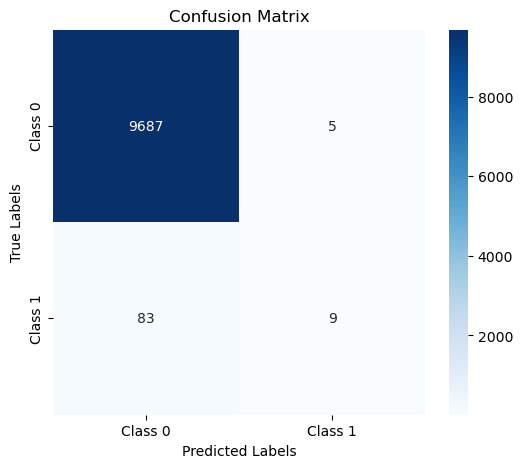

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_val, val_preds)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Assuming you have the true labels in y_val and the predicted labels in val_preds
y_val = y_val  # True labels from the validation set
val_preds = model.predict(X_val)  # Predicted labels from the model

# Calculate Accuracy
accuracy = accuracy_score(y_val, val_preds)

# Calculate Precision
precision = precision_score(y_val, val_preds)

# Calculate Recall
recall = recall_score(y_val, val_preds)

# Calculate F1-Score
f1 = f1_score(y_val, val_preds)

# Calculate ROC-AUC (if binary classification)
roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])  # For binary classification, take the probability of class 1

# Print all metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_val, val_preds))


Accuracy: 0.9910057236304171
Precision: 0.6428571428571429
Recall: 0.09782608695652174
F1-Score: 0.16981132075471697
ROC-AUC: 0.924058838306806

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9692
           1       0.64      0.10      0.17        92

    accuracy                           0.99      9784
   macro avg       0.82      0.55      0.58      9784
weighted avg       0.99      0.99      0.99      9784

